# MBM40

## Packages

In [1]:
from typing import Any
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from numpy import ndarray

from astropy.io import fits
from astropy.io.fits import HDUList
import astropy.units as u

from spectral_cube import SpectralCube, Slice

from astroquery.esasky import ESASky
from astroquery.utils import TableList
from astropy.wcs import WCS
from reproject import reproject_interp


## Some stuff

### Classes to handle paths


In [2]:
class PathVar():
    
    @staticmethod
    def this_dir() -> str:
        from open_fit import PathTy
        return PathTy.this_dir()

    def __init__(self, path: str = '') -> None:
        self.PATH = path  if path != '' else PathVar.this_dir()

    def split(self) -> list[str]:
        from os import sep
        return self.PATH.split(sep)

    def __add__(self, path: str) -> 'PathVar':
        from os.path import join
        new_path = join(self.PATH,path)
        return PathVar(path=new_path)
     
    def __sub__(self, up: int) -> 'PathVar':
        from os.path import join
        path_list = self.split()
        new_path = join(*path_list[:-up])
        return PathVar(path=new_path)
     

class FileVar(PathVar):

    def __init__(self, filename: str | list[str], dirpath: str | PathVar = '') -> None:
        self.DIR  = dirpath if isinstance(dirpath, PathVar) else PathVar(path = dirpath)
        self.FILE = filename

    def path(self) -> str | list[str]:
        from os.path import join
        filename = self.FILE 
        if isinstance(filename,str): 
            return (self.DIR + filename).PATH
        else:
            return [(self.DIR + name).PATH for name in filename]
    

### Functions

In [26]:
def hotpx_remove(data: ndarray) -> ndarray:
    """To remove hot pixels from the image

    Parameters
    ----------
    data : ndarray
        spectrum data

    Returns
    -------
    data : ndarray
        spectrum data without `NaN` values
    
    Notes
    -----
    The function replacing `NaN` values from the image, if there are.
    I did not implement this function, I took it from [*astropy documentation*](https://docs.astropy.org/en/stable/convolution/index.html)

    """
    from astropy.convolution import Gaussian2DKernel, interpolate_replace_nans
    # check the presence of `NaNs`
    if True in np.isnan(data):
        # build a gaussian kernel for the interpolation
        kernel = Gaussian2DKernel(x_stddev=1)
        # remove the `NaNs`
        data = interpolate_replace_nans(data, kernel)
    return data



def showfits(data: np.ndarray, v: int = -1, title: str = '', n: int = None, norm: str ='linear', dim: list[int] = [10,7], labels: tuple[str,str] = ('',''), ticks: tuple[ndarray[float] | None, ndarray[float] | None] = (None,None), tickslabel: tuple[ ndarray[str | float] | None,  ndarray[str | float] | None] = (None, None),**kwimg) -> None:
    """Function to display the fits image.
    filename
    You can display simply the image or set a figure number and a title.

    :param data: image matrix of fits file
    :type data: np.ndarray
    :param v: cmap parameter: 1 for false colors, 0 for grayscale, -1 for reversed grayscale; defaults to -1
    :type v: int, optional
    :param title: title of the image, defaults to ''
    :type title: str, optional
    :param n: figure number, defaults to None
    :type n: int, optional
    :param dim: figure size, defaults to [10,7]
    :type dim: list[int], optional
    """
    plt.figure(n,figsize=dim)
    plt.title(title)
    if v == 1 : color = 'viridis'
    elif v == 0 : color = 'gray'
    else : color = 'gray_r'
    plt.imshow(data, cmap=color, norm=norm, origin='lower',**kwimg)
    plt.colorbar()
    # plt.xlabel(labels[0])
    # plt.ylabel(labels[1])
    # if_stat = lambda tck : tck[0] is None and tck[1] is None  
    # if if_stat(ticks) and not if_stat(tickslabel):
    #     ticks = (np.arange(*tickslabel[0].shape), np.arange(*tickslabel[1].shape))     
    # plt.xticks(ticks[0],tickslabel[0])
    # plt.yticks(ticks[1],tickslabel[1])


def get_data_fit(path: str, lims: list[int | None] = [None,None,None,None], v: int = -1, title: str = '', n: int = None, dim: list[int] = [10,7], hotpx: bool = True, display_plots: bool = True, **imgargs) -> tuple[HDUList, ndarray]:
    """Function to open fits file and extract data.
    
    It brings the path and extracts the data, giving a row image.
    
    You can set a portion of image and also the correction for hotpx.

    It calls the functions: 
      - `hotpx_remove()`
      - `showfits()`

    :param path: path of the fits file
    :type path: str
    :param lims: edges of the fits, defaults to [None,None,None,None]
    :type lims: list[int | None], optional
    :param hotpx: parameter to remove or not the hot pixels, defaults to True
    :type hotpx: bool, optional
    :param v: cmap parameter: 1 for false colors, 0 for grayscale, -1 for reversed grayscale; defaults to -1
    :type v: int, optional
    :param title: title of the image, defaults to ''
    :type title: str, optional
    :param n: figure number, defaults to None
    :type n: int, optional
    :param dim: figure size, defaults to [10,7]
    :type dim: list[int], optional

    :return: `hdul` list of the chosen fits file and `data` of the spectrum
    :rtype: tuple

    .. note:: `lims` parameter controls the x and y extremes in such the form [lower y, higher y, lower x, higher x]
    """
    # open the file
    hdul = fits.open(path)
    # print fits info
    hdul.info()
    # print header
    hdr = hdul[0].header
    print(' - HEADER -')
    print(hdr.tostring(sep='\n'))
    print()

    # data extraction
    # format -> data[Y,X]
    data = hotpx_remove(hdul[0].data) if hotpx else hdul[0].data
    ly,ry,lx,rx = lims
    data = data[ly:ry,lx:rx]
    # hot px correction
    # Spectrum image
    if display_plots == True: showfits(data, v=v,title=title,n=n,dim=dim, **imgargs) 
    return hdul,data


## Spectral Analysis

### Load data


In [14]:
# collect paths
DATA_PATH = PathVar()
DATA_FILE = FileVar(filename='data.txt',dirpath=DATA_PATH)
data_name = np.loadtxt(DATA_FILE.path(), unpack='True', dtype=str)
COLLECTION = FileVar(filename=data_name,dirpath=DATA_PATH) 
# extract paths
paths = COLLECTION.path()

### CO DATA

  - 0 : `'AR_FCRAO.fits'`
  - 1 : `'DEC_FCRAO.fits'`
  - 2 : `'VEL_FCRAO_CO.fits'`
  - 3 : `'MBM40_FCRAO_CO_CLEANED.fits'`
  - 4 : `'MBM40_12CO_xdr.fits'`
  - 5 : '`mbm40_CO-FCRAO.fits`'    


In [5]:
# collect units for ra, dec and vel of 3
_, ra  = get_data_fit(paths[0], display_plots=False)     
_, dec = get_data_fit(paths[1], display_plots=False)     
_, vel = get_data_fit(paths[2], display_plots=False)     
ra = ra[0]
dec = dec[0]
vel = vel[0]
print(ra.shape)
print(dec.shape)
print(vel.shape)

def prepare_data(data):
    step = np.diff(data)[0]
    hpx = len(data)//2
    hval = data[hpx]
    cpx = hpx + 1.5 if len(data)%2 == 0 else len(data)/2
    cval = hval + step/2
    return cpx, cval, step

ra_cpx, ra_cval, ra_step = prepare_data(ra)
dec_cpx, dec_cval, dec_step = prepare_data(dec)
vel_cpx, vel_cval, vel_step = prepare_data(vel)



Filename: /home/bernardo/Scrivania/FISICA/ASTROFISICA/&Argomenti/Filaments/MBM40/AR_FCRAO.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       8   (130, 1)   float64   
 - HEADER -
SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                  -64 / number of bits per data pixel                  
NAXIS   =                    2 / number of data axes                            
NAXIS1  =                  130 / length of data axis 1                          
NAXIS2  =                    1 / length of data axis 2                          
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
END                                                                                                                    

In [ ]:
# DO NOT USED
hdul, co_data = get_data_fit(paths[3],display_plots=False)   
print(co_data.shape)

def add_cart(name,value,comment=''):
    hdul[0].header[name] = value
    hdul[0].header.comments[name] = comment


hdul[0].header['OBJECT'] = 'FCRAO MBM40 CO cleaned map'
hdul[0].header.comments['OBJECT'] = 'Object Name'
add_cart('CTYPE1','RA      ','1st axis type')
add_cart('CRVAL1',ra_cval,'Reference pixel value')
add_cart('CRPIX1',ra_cpx,'Reference pixel')
add_cart('CDELT1',np.round(ra_step,decimals=5),'Pixel size in world coordinate units')
add_cart('CROTA1',0.0,'Axis rotation in degrees')
add_cart('CTYPE2','DEC     ','2st axis type')
add_cart('CRVAL2',dec_cval,'Reference pixel value')
add_cart('CRPIX2',dec_cpx,'Reference pixel')
add_cart('CDELT2',np.round(dec_step,decimals=5),'Pixel size in world coordinate units')
add_cart('CROTA2',0.0,'Axis rotation in degrees')
add_cart('CTYPE3','VELO-LSR','3st axis type')
add_cart('CRVAL3',vel_cval*1000,'Reference pixel value')
add_cart('CRPIX3',vel_cpx,'Reference pixel')
add_cart('CDELT3',np.round(vel_step,decimals=2)*1000,'Pixel size in world coordinate units')
add_cart('CROTA3',0.0,'Axis rotation in degrees')
add_cart('EQUINOX',2000.00,'Equinox of coordinates (if any)')
add_cart('BUNIT','K','Units of pixel data values')
hdul[0].header['OBSERVER'] = 'FCRAO : Five College Radio Astronomy Observatory'

up_header = hdul[0].header

fits.writeto('MBM40_FCRAO_CO_CLEANED_upheader.fits', co_data, up_header, overwrite=True)


False
False
False


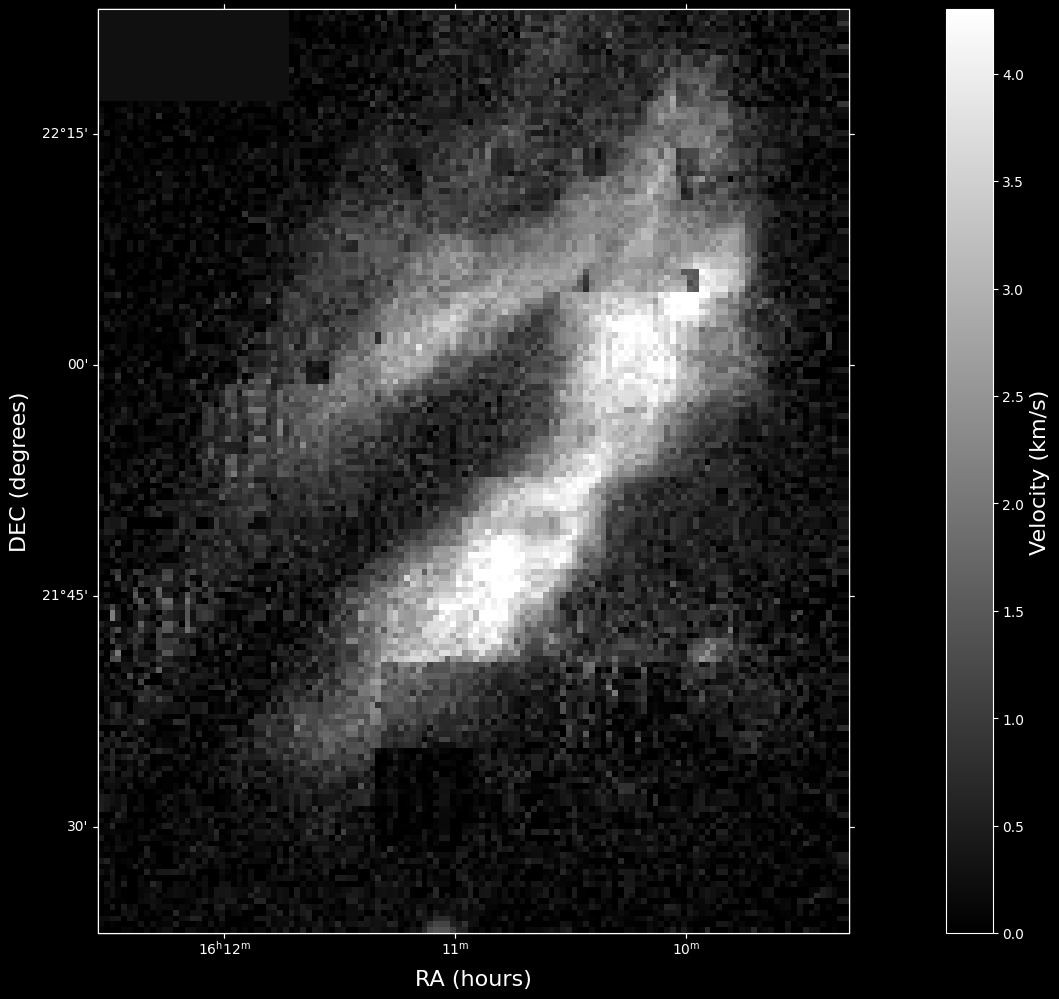

In [6]:
co_cube : SpectralCube = SpectralCube.read(paths[3]).with_spectral_unit(u.km / u.s)

n_vel, n_dec, n_ra = co_cube.world[:]

pos = np.round(n_vel[:,0,0].value,2) == np.round(vel,2)
print((pos==False).any())
pos = np.round(n_dec[0,:,0].value,2) == np.round(dec,2)
print((pos==False).any())
pos = np.round(n_ra[0,0,:].value,2) == np.round(ra,2)
print((pos==False).any())



mom0 = co_cube.moment0()
mom1 = co_cube.moment1()

fig = plt.figure(figsize=(18, 12))
ax = fig.add_subplot(111, projection=mom0.wcs)

# Display the moment map image
im = ax.imshow(mom0.hdu.data, cmap='gray', origin='lower', vmin=0, vmax=vel[-1])


# Add axes labels
ax.set_xlabel("RA (hours)", fontsize=16)
ax.set_ylabel("DEC (degrees)", fontsize=16)

# Add a colorbar
cbar = plt.colorbar(im, pad=.07)
cbar.set_label('Velocity (km/s)', size=16)

plt.show()

### HI 21cm

  - 6 : `'GALFA_HI_RA+DEC_236.00+26.35_N.fits'`
  - 7 : `'GALFA_HI_RA+DEC_236.00+18.35_N.fits'`
  - 8 : `'GALFA_HI_RA+DEC_244.00+18.35_W.fits'`
  - 9 : `'GALFA_HI_RA+DEC_244.00+26.35_W.fits'`


In [7]:
def select_channel(cube: SpectralCube, vel_val: float) -> Slice:
    ch_pos = np.argmin(np.abs(cube.with_spectral_unit(vel_u).spectral_axis - vel_val*vel_u))
    return cube[ch_pos, : , :]

# correct an unit
vel_u = u.km / u.s
u.add_enabled_units(u.def_unit(['K (Tb)'], represents=u.K))
vel_range = (vel[0]*vel_u, vel[-1]*vel_u)
ra_range  = (243.5*u.deg,242*u.deg)
dec_range = (21*u.deg,22.608326*u.deg)

channel = 3.4


In [ ]:
cube1 : SpectralCube = SpectralCube.read(paths[8]).with_spectral_unit(vel_u).subcube(*ra_range,*dec_range,*vel_range)
print(cube1)
cube1_slice = select_channel(cube1,channel)

del cube1

In [ ]:

dec_range = (22.608326*u.deg,23*u.deg)
cube2 : SpectralCube = SpectralCube.read(paths[9]).with_spectral_unit(vel_u).subcube(*ra_range,*dec_range,*vel_range)
print(cube2)

cube2_slice = select_channel(cube2,channel)

del cube2

In [ ]:
co_m0 = co_cube.moment0()
fig = plt.figure(figsize=(13,7))
ax = fig.add_subplot(111,projection=cube1_slice.wcs)

ax.imshow(cube1_slice.hdu.data,cmap='jet',origin='lower')
co_transform = ax.get_transform(co_m0.wcs)
xlim = ax.get_xlim()
ylim = ax.get_ylim()
levels = (2,3,4)
ax.contour(co_m0.hdu.data,cmap='gray',levels=levels,transform=co_transform)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
plt.show()

In [ ]:
dec1, ra1 = cube1_slice.world[:]
dec2, ra2 = cube2_slice.world[:]
dec1 = dec1[:,0]
dec2 = dec2[:,0]


lag1 = np.diff(dec1).round(decimals=7)
lag2 = np.diff(dec2).round(decimals=7)
print('lag:', np.intersect1d(lag1,lag2))

sel_d1 = dec1[dec1 >= dec2[0]]
sel_d2 = dec2[dec2 <= dec1[-1]]

print(sel_d1,dec1[-1])
print(sel_d2,dec2[0])
print(sel_d1-sel_d2)
print((sel_d1-sel_d2)/lag1[0])
print(len(dec1)-(sel_d1-sel_d2)/lag1[0],len(dec1))

ch_slice1 = cube1_slice.hdu.data
ch_slice2 = cube2_slice.hdu.data
print(ch_slice1.shape)
print(ch_slice2.shape)
ch_slice = np.append(ch_slice1[:-1],ch_slice2,axis=0)
Hdec = np.append(dec1[:-1],dec2)
Hra = ra1.copy()[0,:]
print(Hra.shape)
print(Hdec.shape)
print(ch_slice.shape)
plt.figure(figsize=(13,15))
plt.imshow(ch_slice, origin='lower')
plt.xticks(np.arange(len(Hra))[::5],Hra[::5].value,rotation=20)
plt.yticks(np.arange(len(Hdec))[::5],Hdec[::5].value)
plt.show()


In [8]:
vel_range = (vel[0]*vel_u, vel[-1]*vel_u)
ra_range  = (248*u.deg,238*u.deg)
dec_range = (17*u.deg,24*u.deg)

cube1 : SpectralCube = SpectralCube.read(paths[8]).with_spectral_unit(vel_u).subcube(*ra_range,*dec_range,*vel_range)
print(cube1)
hi_m01 = cube1.moment0()

del cube1

dec_range = (22.6*u.deg,27*u.deg)
cube2 : SpectralCube = SpectralCube.read(paths[9]).with_spectral_unit(vel_u).subcube(*ra_range,*dec_range,*vel_range)
print(cube2)

hi_m02 = cube2.moment0()


del cube2


SpectralCube with shape=(4, 337, 496) and unit=K:
 n_x:    496  type_x: RA        unit_x: deg    range:   239.741658 deg:  247.991675 deg
 n_y:    337  type_y: DEC       unit_y: deg    range:    17.008331 deg:   22.608342 deg
 n_s:      4  type_s: VOPT      unit_s: km / s  range:        1.840 km / s:       4.049 km / s
SpectralCube with shape=(4, 264, 496) and unit=K:
 n_x:    496  type_x: RA        unit_x: deg    range:   239.741658 deg:  247.991675 deg
 n_y:    264  type_y: DEC       unit_y: deg    range:    22.608326 deg:   26.991668 deg
 n_s:      4  type_s: VOPT      unit_s: km / s  range:        1.840 km / s:       4.049 km / s


13.497548 87.893074


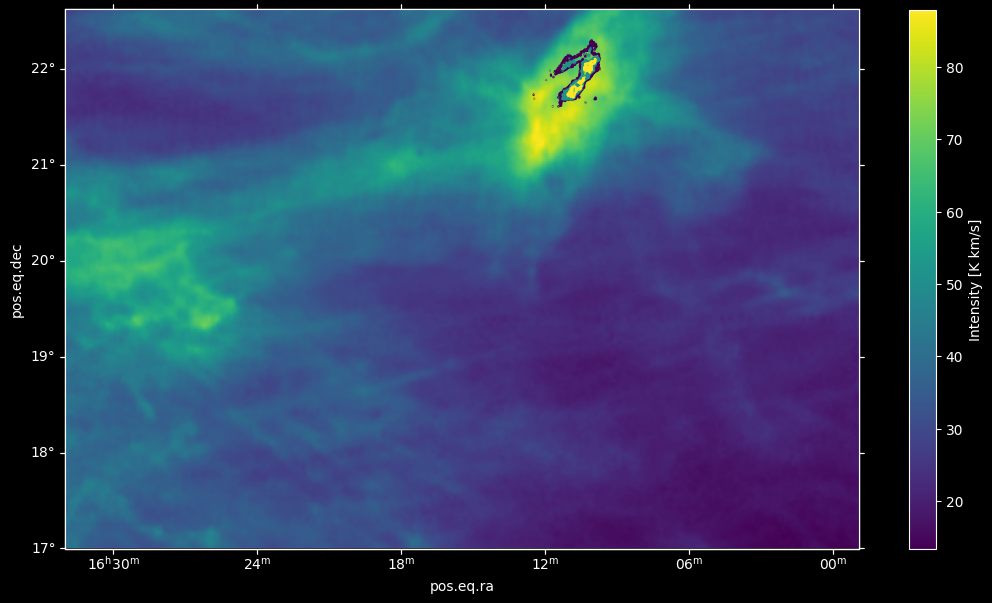

In [11]:
co_m0 = co_cube.moment0()
fig = plt.figure(figsize=(13,7))
ax = fig.add_subplot(111,projection=hi_m01.wcs)

print(hi_m01.hdu.data.min(),hi_m01.hdu.data.max())
img_hi = ax.imshow(hi_m01.hdu.data,cmap='viridis',origin='lower')
cbar_hi = plt.colorbar(img_hi, fraction=0.046)
cbar_hi.set_label('Intensity [K km/s]')
co_transform = ax.get_transform(co_m0.wcs)
xlim = ax.get_xlim()
ylim = ax.get_ylim()
levels = (2,3,4)
img_co = ax.contour(co_m0.hdu.data,cmap='viridis',levels=levels,transform=co_transform)
# cbar_hi = plt.colorbar(img_co, orientation='horizontal',  fraction=0.046, pad=0.07)
# cbar_hi.set_label('Intensity [K km/s]')
ax.set_xlim(xlim)
ax.set_ylim(ylim)
plt.show()

In [ ]:
fig = plt.figure(figsize=(13,7))
ax = fig.add_subplot(111,projection=hi_m01.wcs)

print(hi_m01.hdu.data.min(),hi_m02.hdu.data.max())
img_hi = ax.imshow(hi_m02.hdu.data,cmap='viridis',origin='lower',vmin=35,vmax=60)
cbar_hi = plt.colorbar(img_hi, fraction=0.046)
cbar_hi.set_label('Intensity [K km/s]')
co_transform = ax.get_transform(co_m0.wcs)
xlim = ax.get_xlim()
ylim = ax.get_ylim()
levels = (2,3,4)
img_co = ax.contour(co_m0.hdu.data,cmap='viridis',levels=levels,transform=co_transform)
# cbar_hi = plt.colorbar(img_co, orientation='horizontal',  fraction=0.046, pad=0.07)
# cbar_hi.set_label('Intensity [K km/s]')
ax.set_xlim(xlim)
ax.set_ylim(ylim)
plt.show()

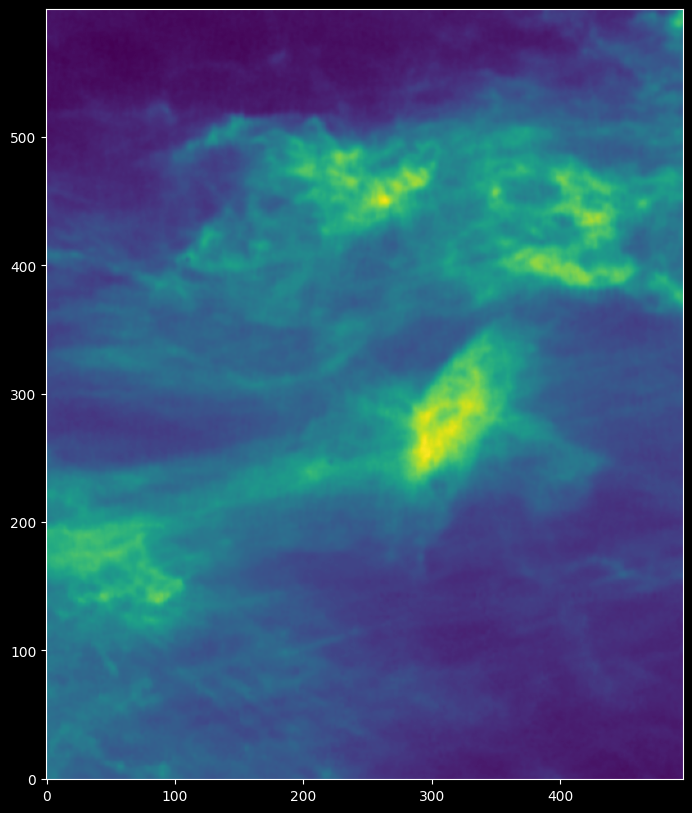

In [13]:
hi_data1 = hi_m01.hdu.data
hi_data2 = hi_m02.hdu.data
data = np.append(hi_data1[:-1],hi_data2,axis=0)
plt.figure(figsize=(17,10))
plt.imshow(data,origin='lower')
plt.show()

### 60-100 micron

Data files:

 - 10 : `IRAS-60_RA+DEC_242.64+21.822.fits`
 - 11 : `IRAS-100_RA+DEC_242.64+21.822.fits`

Filename: /home/bernardo/Scrivania/FISICA/ASTROFISICA/&Argomenti/Filaments/MBM40/IRAS-60_RA+DEC_242.64+21.822.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     133   (1000, 1000)   float32   
 - HEADER -
SIMPLE  =                    T / Written by SkyView Thu Oct 17 10:19:07 EDT 2024
BITPIX  =                  -32 / 4 byte floating point                          
NAXIS   =                    2 / Two dimensional image                          
NAXIS1  =                 1000 / Width of image                                 
NAXIS2  =                 1000 / Height of image                                
CRVAL1  =   242.64199999999994 / Reference longitude                            
CRVAL2  =               21.822 / Reference latitude                             
RADESYS = 'FK5     '           / Coordinate system                              
EQUINOX =               2000.0 / Epoch of the equinox                           
CTYPE1  = 'RA-

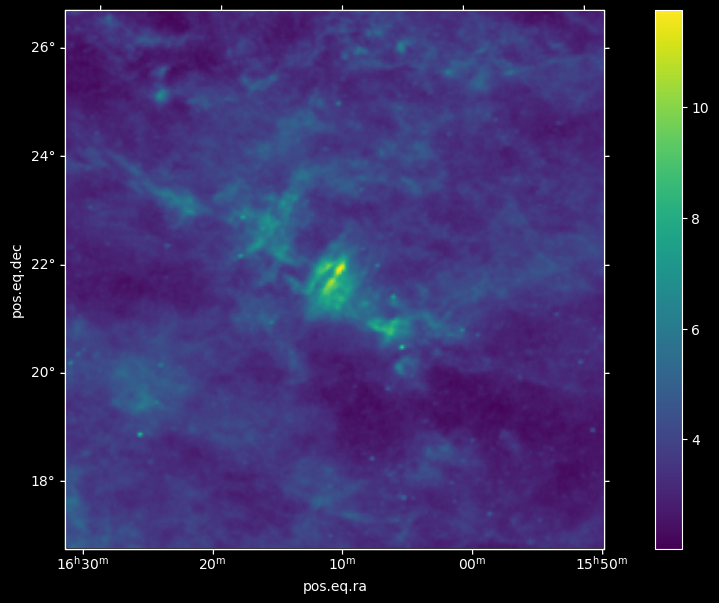

In [39]:
ir60_hdul, ir60_data   = get_data_fit(paths[10],display_plots=False) 
ir100_hdul, ir100_data = get_data_fit(paths[11],display_plots=False) 

ir100_wcs = WCS(ir100_hdul[0].header)

fig = plt.figure(figsize=(13,7))
ax = fig.add_subplot(111,projection=ir100_wcs)
ir_img = ax.imshow(ir100_data)
plt.colorbar(ir_img)
plt.show()

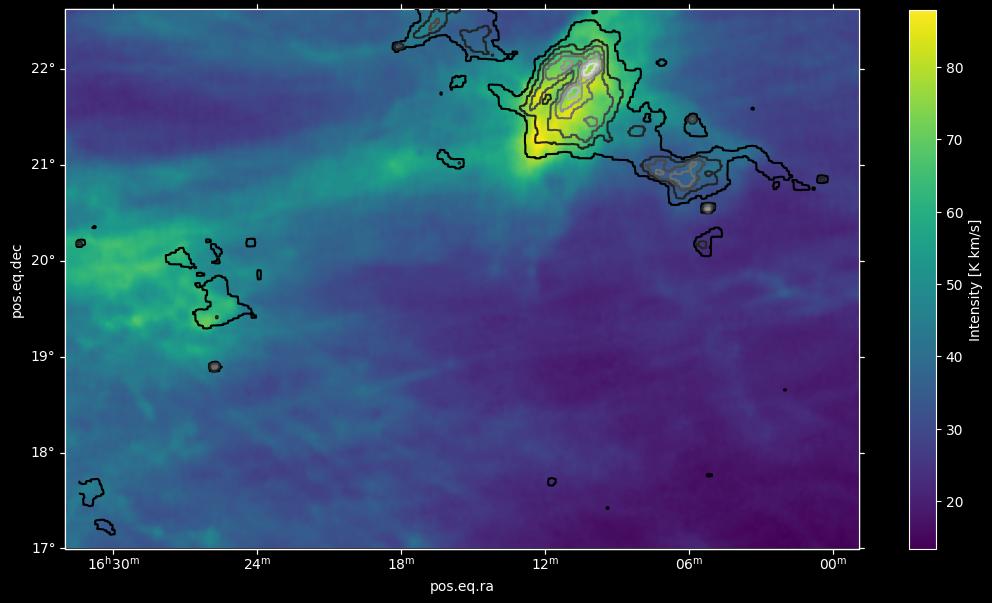

In [41]:
fig = plt.figure(figsize=(13,7))
ax = fig.add_subplot(111,projection=hi_m01.wcs)

img_hi = ax.imshow(hi_m01.hdu.data,cmap='viridis',origin='lower')
cbar_hi = plt.colorbar(img_hi, fraction=0.046)
cbar_hi.set_label('Intensity [K km/s]')
ir_transform = ax.get_transform(ir100_wcs)
xlim = ax.get_xlim()
ylim = ax.get_ylim()
levels = (5,6,7,8,9,10,11,12)
img_ir = ax.contour(ir100_data,cmap='gray',levels=levels,transform=ir_transform)
# cbar_hi = plt.colorbar(img_co, orientation='horizontal',  fraction=0.046, pad=0.07)
# cbar_hi.set_label('Intensity [K km/s]')
ax.set_xlim(xlim)
ax.set_ylim(ylim)
plt.show()